# Guide to Using the Notch and LOCoR pipelines

#### Required packages
1. mpyfit, a python wrapped version of mpfit in c: https://github.com/evertrol/mpyfit
2. python-bls, a python wrapped version of the fortran BLS code: https://github.com/dfm/python-bls
3. tqdm, the nice progress bar package: pip install tqdm

#### Start by importing some of the usual things

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['lines.linewidth']   = 2
mpl.rcParams['axes.linewidth']    = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.labelsize']   = 10
mpl.rcParams['xtick.labelsize']   = 10
mpl.rcParams['axes.labelsize']    = 10
mpl.rcParams['legend.numpoints']  = 1
mpl.rcParams['axes.labelweight']  = 'semibold'
mpl.rcParams['axes.titlesize']    = 10
mpl.rcParams['axes.titleweight']  = 'semibold'
mpl.rcParams['font.weight']       = 'semibold'

#### Next import the codes that provide an interface to Notch and LOCoR 

In [3]:
import interface as thymeNL
import lcfunctions as lcfunc

### Data
In this example notebook, we'll be using the TESS short cadence data from sector 11 of Aaron's favourite planet host: HIP 67522 <br>
This came pre-packaged in the tessdata subdirectory. There you will find a few different THYME planet hosts to play with.<br>

##### First define a fresh target object and assign it the data for HIP 67522

In [4]:
target_name = 166527623
datafile = 'tessdata/tess2019112060037-s0011-0000000166527623-0143-s_lc.fits'

hip67522 = thymeNL.target(target_name)
hip67522.load_data_tess(datafile)


In [10]:
import pickle
outputfile = open('testfile.pkl','wb')
pickle.dump(hip67522,outputfile)
outputfile.close()

inputfile = open('testfile.pkl','rb')
readin_var = pickle.load(inputfile)
inputfile.close()
print(readin_var.data)

[(1599.95768024, 1.00499221, 1.00096969, 0., 0, 0.)
 (1599.95906914, 1.00411139, 1.0002825 , 0., 0, 0.)
 (1599.96462475, 1.00461384, 1.00080516, 0., 0, 0.) ...
 (1623.8935936 , 0.99497414, 0.99481859, 0., 0, 0.)
 (1623.89498245, 0.99417769, 0.99401646, 0., 0, 0.)
 (1623.8963713 , 0.99518345, 0.99505984, 0., 0, 0.)]


The hip67522 target object has a bunch of different attributes and functions that do all the basic things that the Notch and LOCoR pipelines are capable of.<br>
At this point, all the data is stored in hip67522.data, which is a numpy recarray

###### Start by checking out what is in the data itself

In [19]:
display(hip67522.data)

#hip67522.plotlc()

rec.array([(1599.95768024, 1.00499221, 1.00096969, 0., 0, 0.),
           (1599.95906914, 1.00411139, 1.0002825 , 0., 0, 0.),
           (1599.96462475, 1.00461384, 1.00080516, 0., 0, 0.), ...,
           (1623.8935936 , 0.99497414, 0.99481859, 0., 0, 0.),
           (1623.89498245, 0.99417769, 0.99401646, 0., 0, 0.),
           (1623.8963713 , 0.99518345, 0.99505984, 0., 0, 0.)],
          dtype=[('t', '<f8'), ('fraw', '<f8'), ('fcor', '<f8'), ('s', '<f8'), ('qual', '<i8'), ('divisions', '<f8')])

### -
In the above output, 't' is the time of each data point, fraw is the SAP flux, fcor is the PDCSAP flux, qual is the quality flag, 's' is the arclength parameter, and 'divisions' is the divisioning from k2sff, the last two are only used with K2 data from k2sff so ignore mostly
##### Plot the lightcurve

plotting can be done directly with plt.plot(hip67522.data.t,hip67522.data.fcor,'.'), which is good for custom plots, or for quick inspection using the following:

<IPython.core.display.Javascript object>


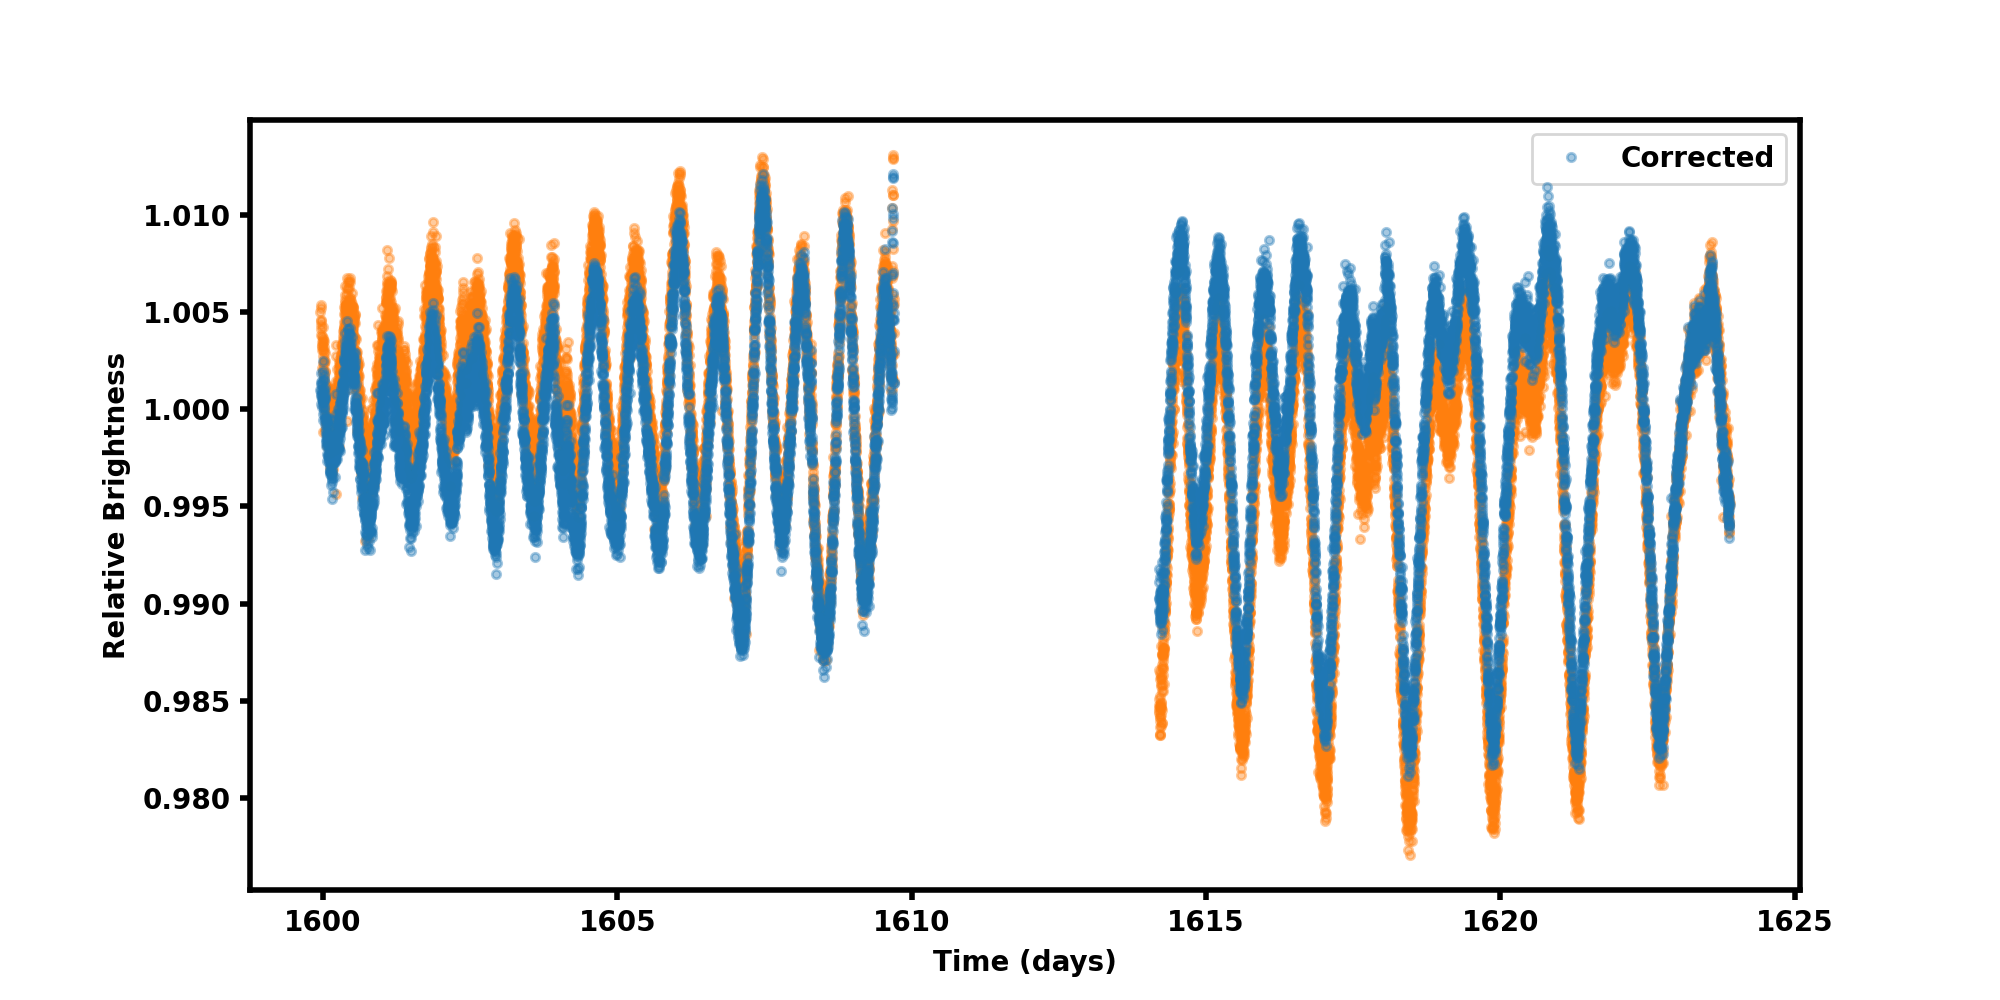

In [20]:
%matplotlib notebook
hip67522.plotlc(alpha=0.4)


#### In the above plot, if you zoom in on time 1604, you'll splot the first transit of HIP 67522 b!

The wiggles from the rotational spot variabilty are super big, and it's hard to pick out the planet, so run Notch on the lightcurve:<br>
Here, the window parameter is the window size used (in days), and the mindbic parameter is the minimum Bayesian Information Criterion (BIC) difference between a notch and notch-free model required to accept the notch model <br>
For almost all cases, setting this to -1.0 is going to be fine. A bigger number means more evidence is required.<br>
The defaults are used below

### What does notch actually do?
       1. At each point in the lightcurve, a polynomial + notch model, and a solo polynomial model are fit to a window of data (~0.5 to 1 day usually). 
       2. This fit is iterated up to 10 times to clip outliers like flares (in red)
       3. The notch + polynomial model fits alot better than the solo polynomial model when a transit is present, this gives a large positive Bayesian Information Criterion difference between the two models, favouring the one with the notch.

Below: Top plot is a window on a transit in a varying lightcurve, bottom plot is the case where there is no transit at the window center, but a transit nearer the edge of the window

<IPython.core.display.Javascript object>


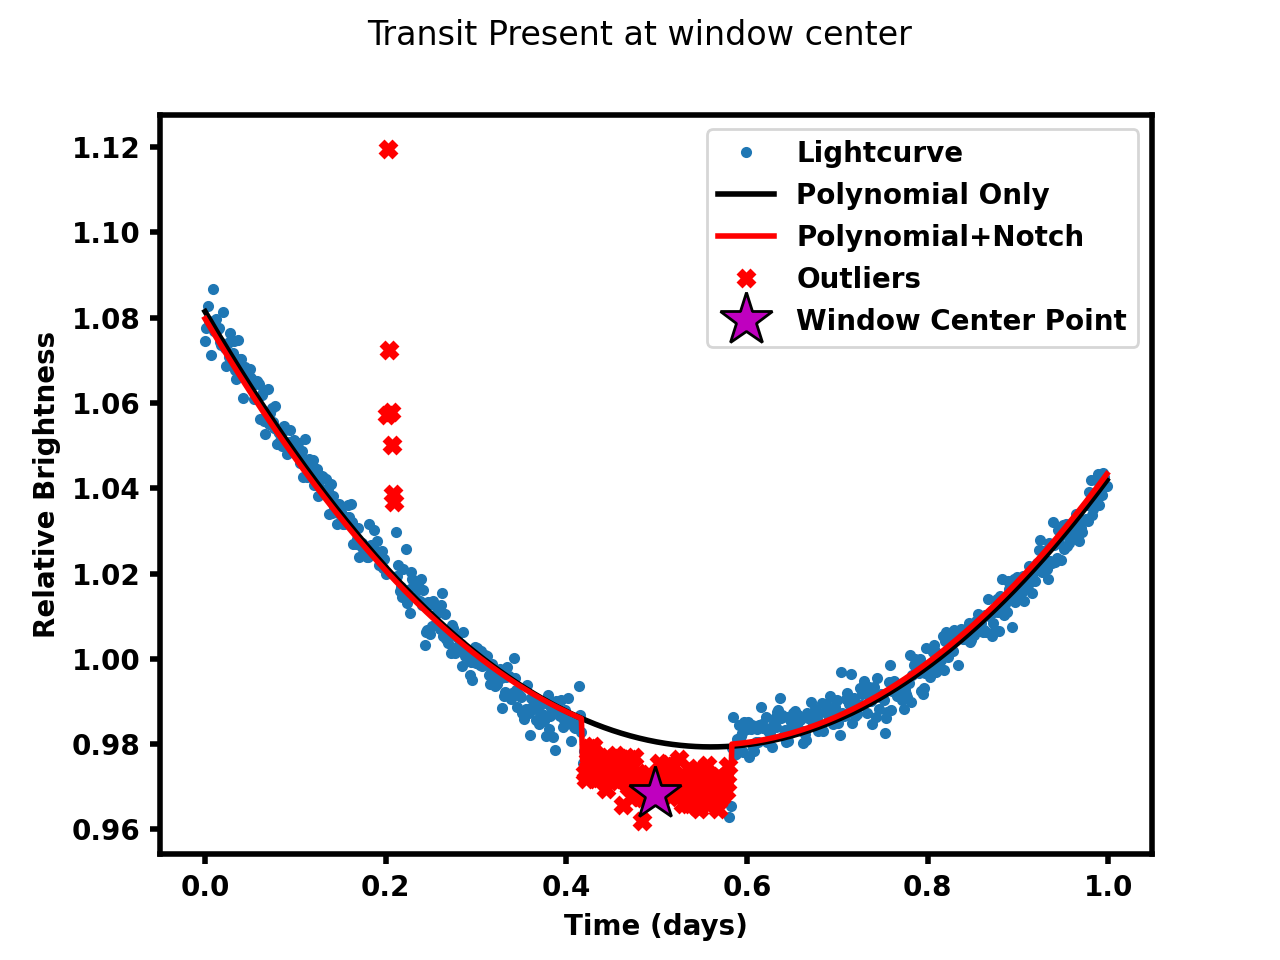

<IPython.core.display.Javascript object>


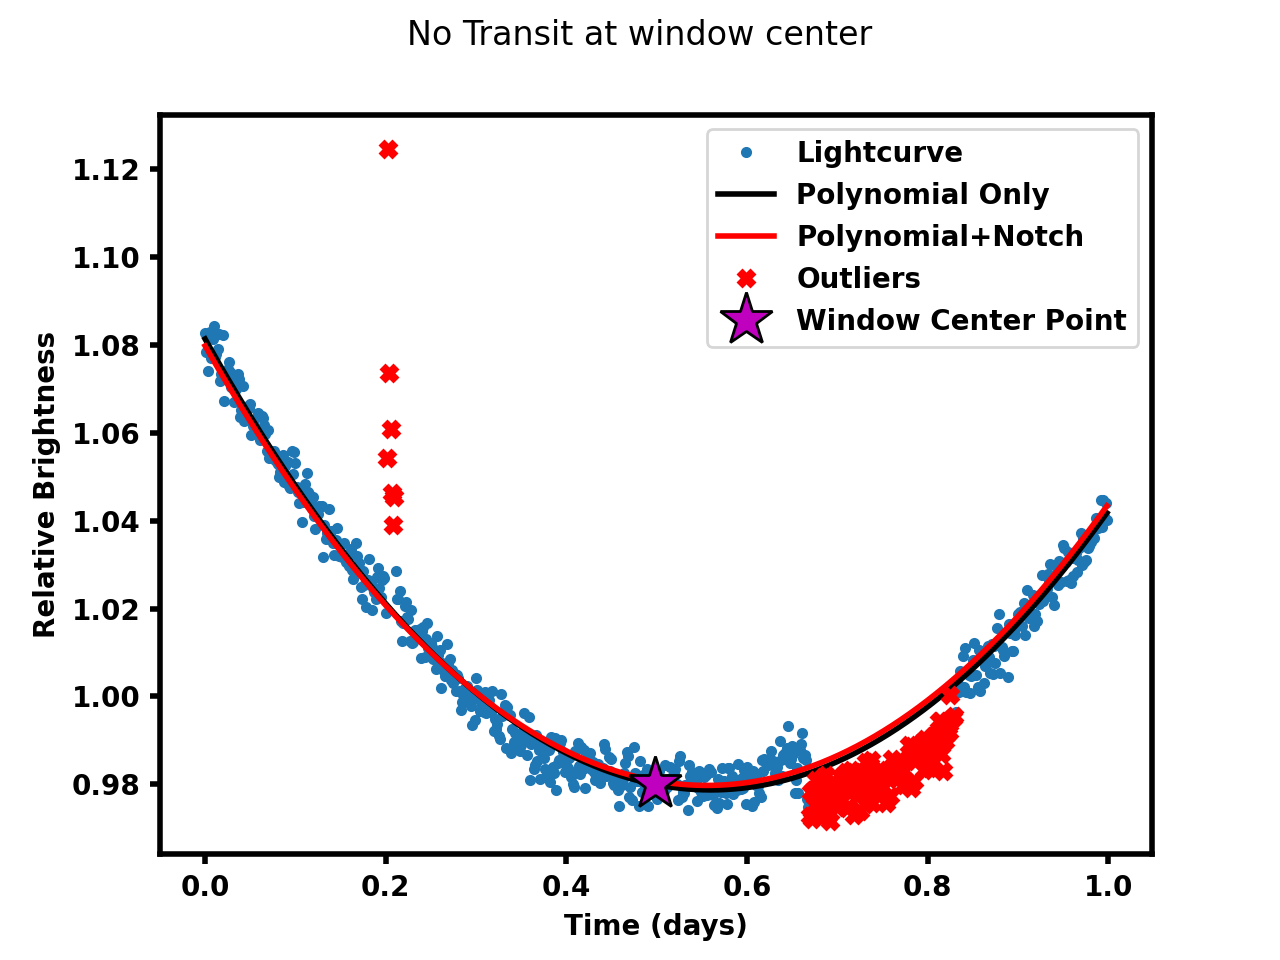

Text(0.5, 0.98, 'No Transit at window center')

In [21]:
from importlib import reload
reload(lcfunc)

t,lc,lc_All,fitpoly,trmod,tpoint,outl = lcfunc.showmenotch()

%matplotlib notebook
figx,axx = plt.subplots()
axx.plot(t,lc_All,'.',label='Lightcurve')
axx.plot(t,fitpoly,'k',label='Polynomial Only')
axx.plot(t,trmod,'r',label='Polynomial+Notch')
axx.plot(t[outl],lc_All[outl],'Xr',label='Outliers')
axx.plot(t[tpoint],lc_All[tpoint],'m*',markersize=20,markeredgecolor='k',label='Window Center Point')
axx.legend()
axx.set_ylabel('Relative Brightness')
axx.set_xlabel('Time (days)')
figx.suptitle('Transit Present at window center')

t,lc,lc_All,fitpoly,trmod,tpoint,outl = lcfunc.showmenotch(ontr=False)
figy,axy = plt.subplots()
axy.plot(t,lc_All,'.',label='Lightcurve')
axy.plot(t,fitpoly,'k',label='Polynomial Only')
axy.plot(t,trmod,'r',label='Polynomial+Notch')
axy.plot(t[outl],lc_All[outl],'Xr',label='Outliers')
axy.plot(t[tpoint],lc_All[tpoint],'m*',markersize=20,markeredgecolor='k',label='Window Center Point')
axy.legend()
axy.set_ylabel('Relative Brightness')
axy.set_xlabel('Time (days)')
figy.suptitle('No Transit at window center')






## Run notch on the LC, this takes a couple of minutes...

In [23]:
hip67522.run_notch(window=0.5,mindbic=-1.0)


  0%|          | 2/13883 [00:00<13:15, 17.46it/s]

Running notch filter pipeline with windowsize of 0.5 and minimum DeltaBIC of -1.0
Running Detrend


100%|██████████| 13883/13883 [03:32<00:00, 65.29it/s] 


#### Notch filtering is done!
hip67522 now has a new attribute called notch, as well as a record of settings used

The Notch attribute contains:

1. deltabic: The difference in BIC as explained above at each point:
    $\Delta BIC=BIC_{poly} - BIC_{poly+notch}$
2. depth: The notch depths at each point.
3. bicstat: A normalized version of deltabic spanning 0 to 1, with smaller numbers indicating stronger evidence for transit (i.e. upside down because we like transits not flares!!!).
4. badflag: Points that where outliers in one of two ways:
    1. badflag=0: fine
    2. badflag=1: was an outlier in at least one window, these are also fine to keep
    3. badflag=2: something extreme, usually flares or unusal points, generally discard (rare)
5. polyshape: The polynomial part of the model at each point
6. detrend: the lightcurve with polyshape divided out

In [22]:
display('Notch Window Size: ' + str(hip67522.notch_windowsize))
display('Notch mindbic Size: ' + str(hip67522.notch_mindbic))


display(hip67522.notch)

AttributeError: 'target' object has no attribute 'notch_windowsize'

#### Plot the detrended lightcurve:

We can plot the detrended lightcurve again with the plotlc function, if a notch attribute exists, it will be automatic <br>
We can also plot the BIC sequence using the bistat variable

<IPython.core.display.Javascript object>


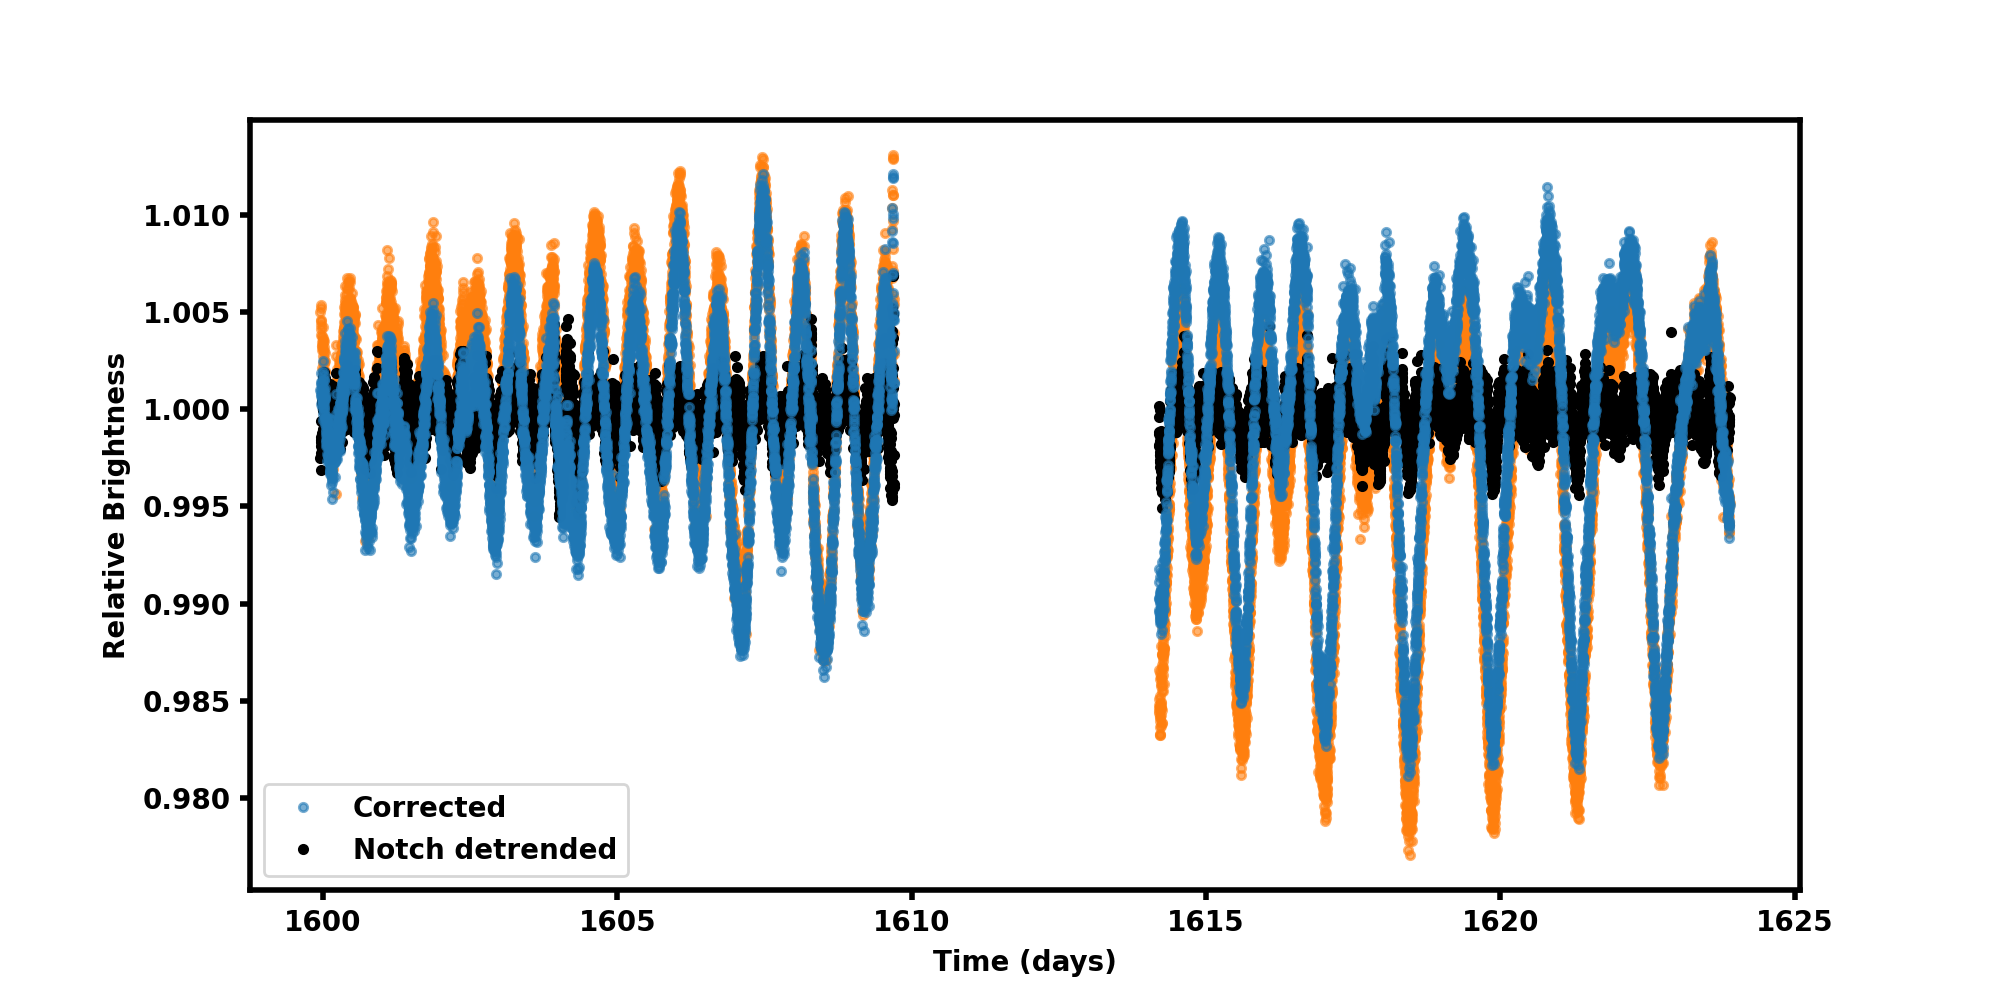

<IPython.core.display.Javascript object>


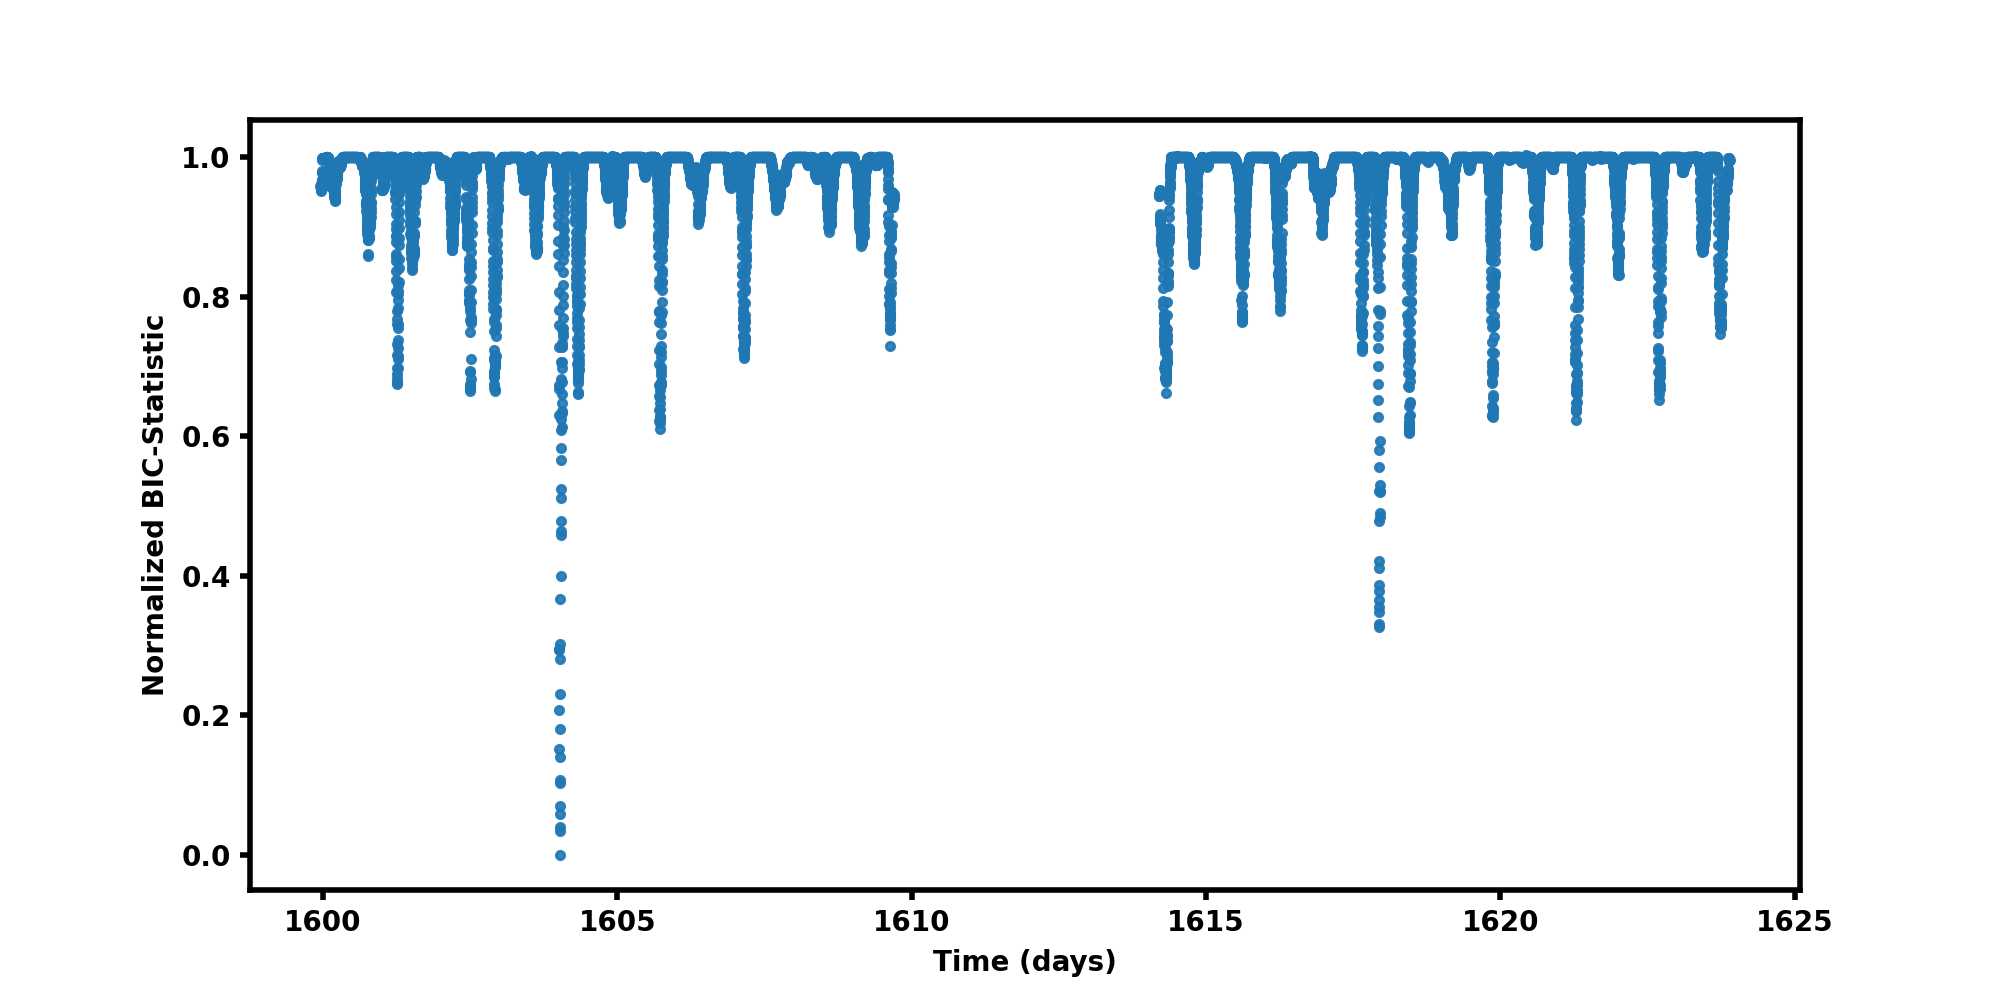

In [9]:
%matplotlib notebook
hip67522.plotlc()

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(hip67522.notch.t,hip67522.notch.bicstat,'.',alpha=0.9)
ax.set_xlabel('Time (days)')
dd =ax.set_ylabel('Normalized BIC-Statistic')

It's pretty clear from the BIC statistic where the two transits likely sit<br>
Seems like the second one is around t=1618 days

Running LOCoR is done in exactly the same way (though this target is not a great case for LOCoR)<br>
For LOCoR, a rotation period must be provided, either as an input to the function call, or as an attribute added to hip67522<br>
A second variable "alias_num" is the minimum rotation period to bunch rotations together to run LOCoR, this is useful when your rotation period is really small and there's not enough points in each rotation.<br>
For TESS short cadence, this usually doesn't matter

### What does LOCoR do?
LOCoR treats each rotation period in the lightcurve as a linear combination of all other rotation periods on the lightcurve: <br>
        $ Period_x = A_1Period_1 + A_2Period_2 + ... + A_nPeriod_n $
<br>
There are a few steps in between fitting for the coefficients ($A_i$), such as interpolating each period onto a uniform timescale, and flagging bad points or incomplete periods. But mostly it's as simple as it sounds.<br>
When a transit is present in a rotation period (and orbiting at the same rotation period), then the transit part of the lightcurve is not well matched by the linear combination of transit-free rotations, and so the transit remains.

Because LOCoR is just solving the normal matrix equation of linear regression, it's pretty quick

In [10]:
hip67522.run_locor(prot=1.4,alias_num=1.0)
display(hip67522.locor)

Running LOCoR with rotation period of 1.4 and alias_num of 1.0
Running Detrend


/Users/acr2877/python/thymecode/core.py:1196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  liblc     = np.array(liblc)
/Users/acr2877/python/thymecode/core.py:1197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  libph     = np.array(libph)
/Users/acr2877/python/thymecode/core.py:1198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  libfl

rec.array([(1599.95768024, 1.00153917, 1), (1599.95906914, 1.00026386, 1),
           (1599.96462475, 0.999654  , 1), ...,
           (1623.8935936 , 1.00060525, 1), (1623.89498245, 0.99957976, 1),
           (1623.8963713 , 1.00147448, 1)],
          dtype=[('t', '<f8'), ('detrend', '<f8'), ('badflag', '<i8')])

##### Now hip67522 has a locor attribute, the plotting will be automatic again

<IPython.core.display.Javascript object>


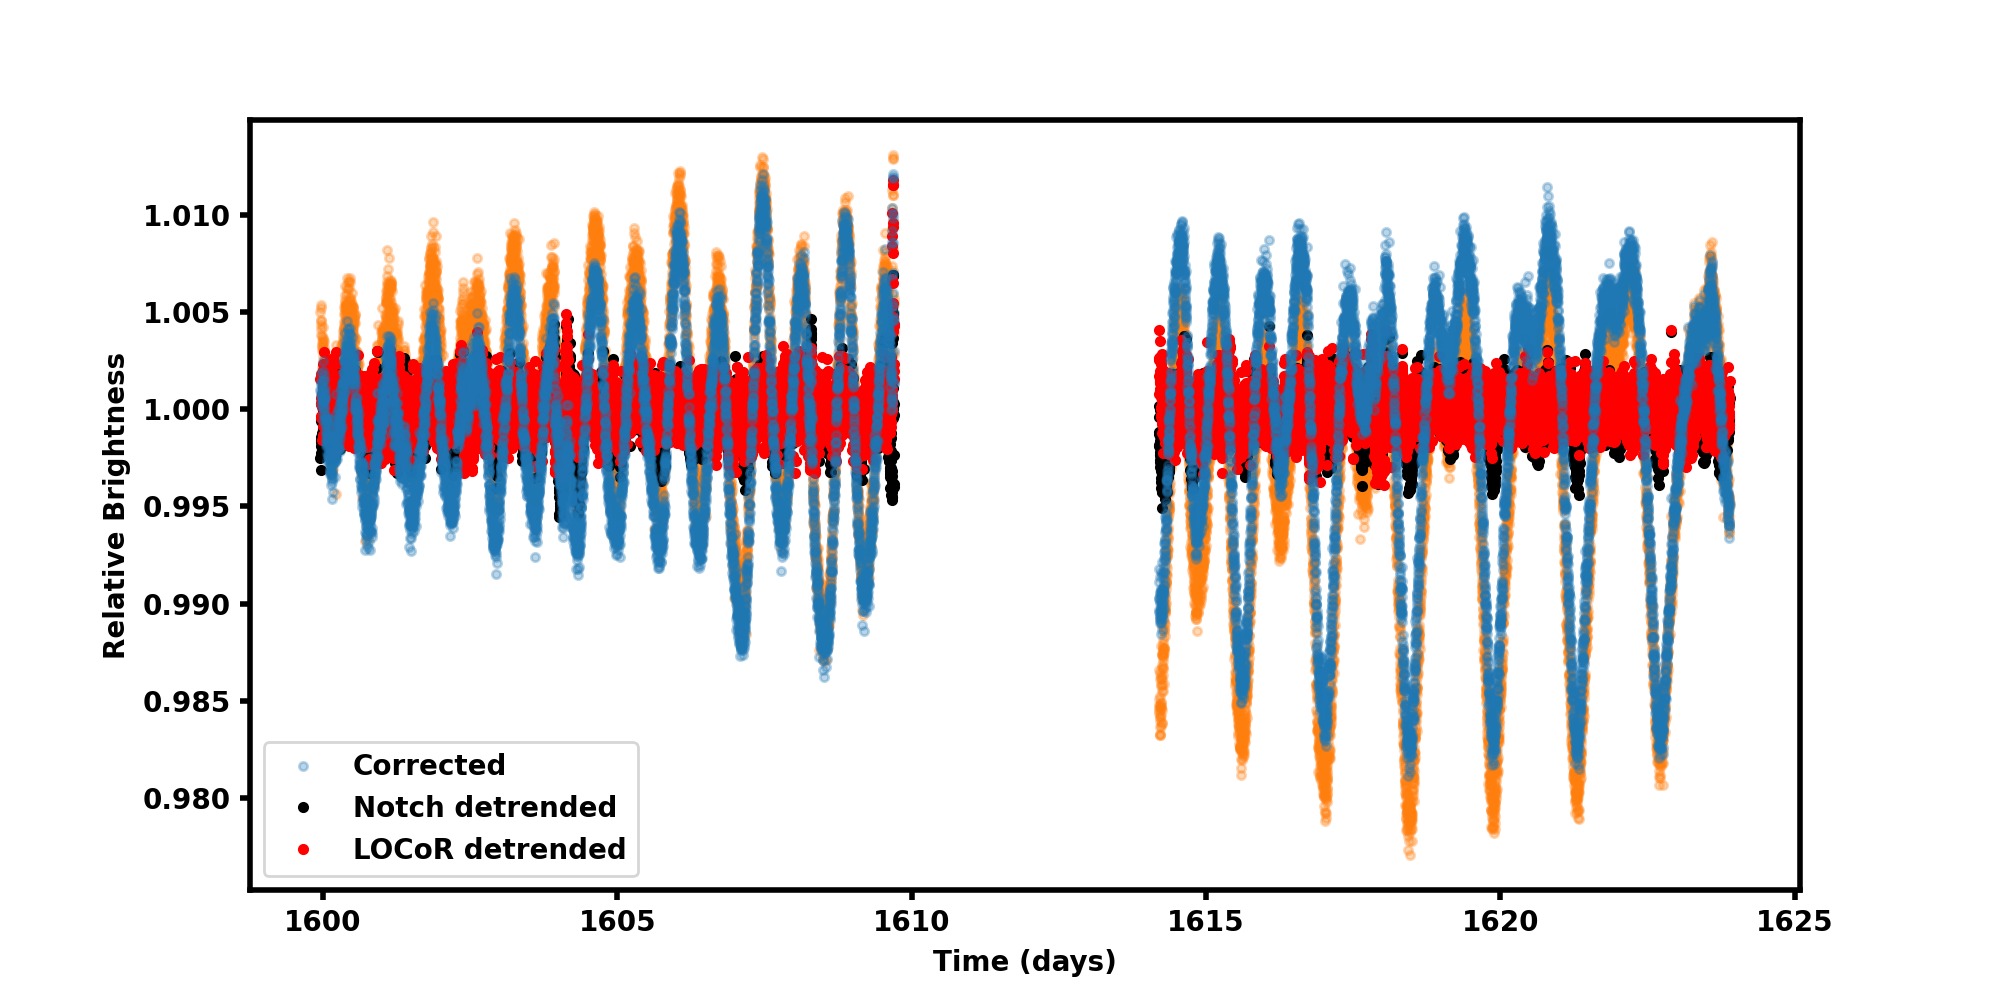

In [11]:
%matplotlib notebook
hip67522.plotlc(alpha=0.3)

## Running BLS search

At this point you could just take the outputs and do whatever you normally like doing for periodic searches.<br>
This package contains some code to run an iterative BLS search, and has some parameters slightly optimised to do so with the BIC statistic as well, start with a relatively normal BLS search.

The following code runs up to 10 searches, clipping out each detected planets before searching again. The search will stop if the current detection strengh is less than snrcut (in sigmas). The rest of the parameters are the normal <br> 
inputs for BLS

Most of the outputs are fairly straight forward:
1. best_per: list of periods detected
2. tdepth: BLS depths for those periods (not trustable)
3. t0: the transit times for the detections
4. det_sigma: Detection sigma, bigger = better
5. period_grid: the grid of searched periods
6. first_powerspec: The BLS power spectrum of the first search (before any clipping happenes post-detection)
7. fist_phase: The best phases for the first search power spectrum
8. dcycle: The transit size in phase units for the detections

#### In the case below, we see that we only got the rotation period at varying detection strengths

We can check that the detections match the rotation period of 1.41 days by running the rotation_checker function.

In [12]:
best_per,tdepth,t0,det_sigma,first_powerspec,period_grid,first_phase,dcycle  = lcfunc.run_bls(hip67522.data,hip67522.notch.detrend,hip67522.notch.badflag,rmsclip=1.5,snrcut=7.0,searchmax=15.0,searchmin=1.00001,binn=300,mindcyc=0.005,maxdcyc=0.3)

# print('Periods')
# display(best_per)
# print('T0')
# display(t0)
# print('Detection Sigmas')
# display(det_sigma)

import vetting
rotation_flag = vetting.rotation_alias_check(best_per,1.41,folds=10,margin=1)
print('flags > 0 indicate matching to a rotation alias')
# print(rotation_flag)

print('Period,  T0,    Sigma, Rot_flag')
for i in range(len(best_per)):
    print(str(best_per[i])[0:5]+', ' + str(t0[i])[0:8]+',  '+str(det_sigma[i])[0:4]+', '+str(rotation_flag[i]))



flags > 0 indicate matching to a rotation alias
Period,  T0,    Sigma, Rot_flag
1.412, 1600.115,  10.2, 1
1.417, 1600.691,  6.14, 1


#### Try again but search the BIC statistic

Note the range of phase widths is peakier now.

In [13]:
best_per,tdepth,t0,det_sigma,first_powerspec,period_grid,first_phase,dcycle  = lcfunc.run_bls_bic(hip67522.data,hip67522.notch.bicstat,hip67522.notch.badflag,rmsclip=1.5,snrcut=7.0,searchmax=15.0,searchmin=1.00001,binn=300,mindcyc=0.003,maxdcyc=0.01)

rotation_flag = vetting.rotation_alias_check(best_per,1.41,folds=10,margin=1)
print('flags > 0 indicate matching to a rotation alias')
# print(rotation_flag)

print('Period,  T0,    Sigma, Rot_flag')
for i in range(len(best_per)):
    print(str(best_per[i])[0:5]+', ' + str(t0[i])[0:8]+', '+str(det_sigma[i])[0:4]+', '+str(rotation_flag[i]))


flags > 0 indicate matching to a rotation alias
Period,  T0,    Sigma, Rot_flag
1.413, 1600.089, 8.66, 1
6.951, 1604.047, 10.9, 0
11.83, 1602.501, 5.47, 0


#### Seems like this time the strongest detection was the planet at ~7 days and transiting at t=1604! 
It also isn't an alias of the rotation period at the 1% level

## More functionality:

There's more functionality and customizability in this code, but the above covers most use cases.<br>
If you're keen to dig a little deeper, open up lcfunctions.py and see how the code we've run above is set up. Every function run through the hip67522 object is detailed in there.<br>
Don't hesitate to ask Aaron for help!

### Next Up, Try doing this for DS-TUC
(tess2018206045859-s0001-0000000410214986-0120-s_lc.fits in tessdata/), and the planet should be at $P_{orb}=8.1$ days 


In [19]:
target_name = 410214986
datafile = 'tessdata/tess2018206045859-s0001-0000000410214986-0120-s_lc.fits'

dstuc = thymeNL.target(target_name)
dstuc.load_data_tess(datafile)

dstuc.run_notch(window=0.5) ##This time the window is 1 day


  0%|          | 11/18085 [00:00<02:48, 107.56it/s]

Running notch filter pipeline with windowsize of 0.5 and minimum DeltaBIC of -1.0
Running Detrend


100%|██████████| 18085/18085 [03:25<00:00, 88.21it/s] 


In [21]:
best_per1,tdepth1,t01,det_sigma1,first_powerspec1,period_grid1,first_phase1,dcycle1  = lcfunc.run_bls(dstuc.data,dstuc.notch.detrend,dstuc.notch.badflag,rmsclip=1.5,snrcut=7.0,searchmax=15.0,searchmin=1.00001)
best_per,tdepth,t0,det_sigma,first_powerspec,period_grid,first_phase,dcycle  = lcfunc.run_bls_bic(dstuc.data,dstuc.notch.bicstat,dstuc.notch.badflag,rmsclip=1.5,snrcut=7.0,searchmax=15.0,searchmin=1.00001)

print('Normal Search Outputs')
rotation_flag1 = vetting.rotation_alias_check(best_per1,1.41,folds=10,margin=1)
print('flags > 0 indicate matching to a rotation alias')
# print(rotation_flag)

print('Period,  T0,    Sigma, Rot_flag')
for i in range(len(best_per1)):
    print(str(best_per1[i])[0:5]+', ' + str(t01[i])[0:8]+', '+str(det_sigma1[i])[0:4]+', '+str(rotation_flag1[i]))

print('------')
print('BIC Statistic Search Outputs')
rotation_flag = vetting.rotation_alias_check(best_per,1.41,folds=10,margin=1)
print('flags > 0 indicate matching to a rotation alias')
# print(rotation_flag)

print('Period,  T0,    Sigma, Rot_flag')
for i in range(len(best_per)):
    print(str(best_per[i])[0:5]+', ' + str(t0[i])[0:8]+', '+str(det_sigma[i])[0:4]+', '+str(rotation_flag[i]))


Normal Search Outputs
flags > 0 indicate matching to a rotation alias
Period,  T0,    Sigma, Rot_flag
8.132, 1332.333, 5.85, 0
------
BIC Statistic Search Outputs
flags > 0 indicate matching to a rotation alias
Period,  T0,    Sigma, Rot_flag
8.148, 1332.319, 22.0, 0
11.13, 1327.321, 11.1, 0
9.301, 1329.190, 6.84, 0


<IPython.core.display.Javascript object>


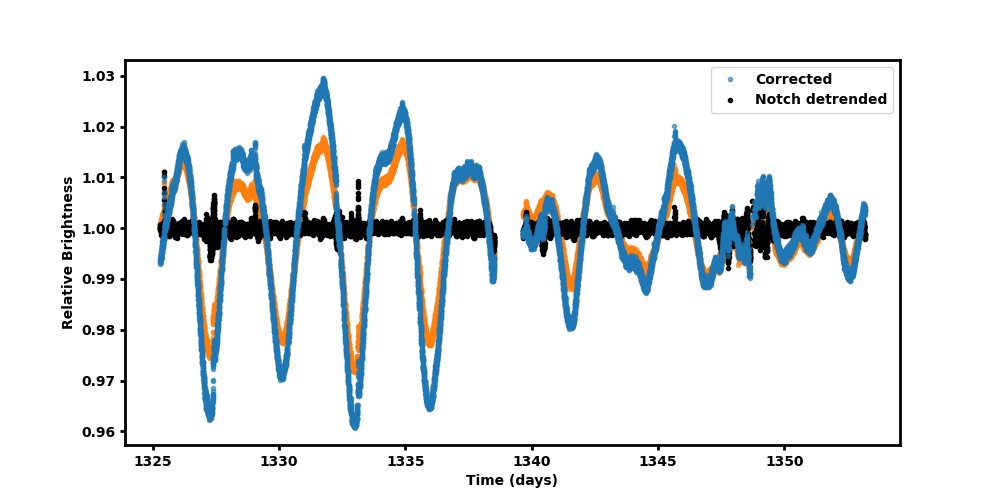

<IPython.core.display.Javascript object>


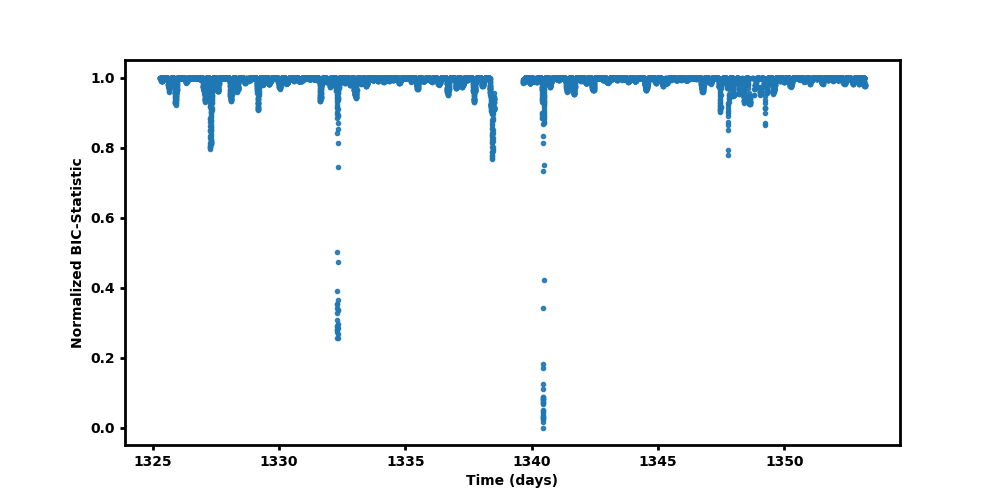

In [51]:
dstuc.plotlc()

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(dstuc.notch.t,dstuc.notch.bicstat,'.',alpha=0.9)
ax.set_xlabel('Time (days)')
dd =ax.set_ylabel('Normalized BIC-Statistic')

#### Another Useful Vetting Tool: Even Odd Plot
Make and even/odd transit plot for DS Tuc and see if the depths agree!<br>
the output eoflag indicates if a point in dstuc.data.t is in an even(0) or odd(1) period

<IPython.core.display.Javascript object>


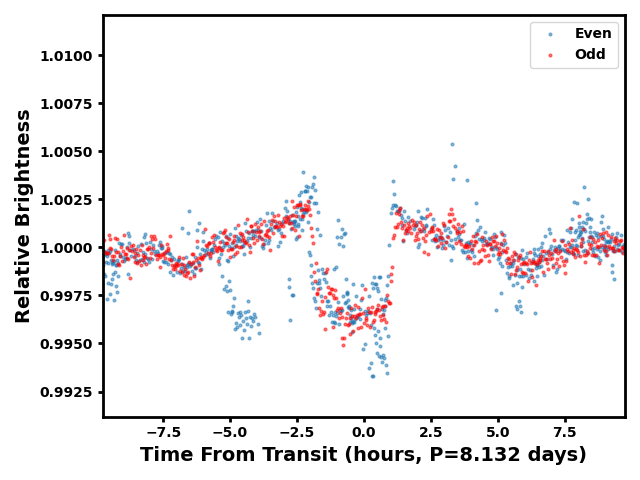

In [25]:
from importlib import reload
reload(vetting)
%matplotlib notebook
eofig,eoax,eoflag = vetting.eo_plot(dstuc.data,dstuc.notch.detrend,dstuc.notch.badflag,best_per1[0],t01[0])


#### Seems like they are in reasonable agreement for the somewhat inaccurate Notch detrending